In [27]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_ROOT = Path("../Master_Data_Sets")

In [28]:
csv_path = DATA_ROOT / "Intel_PC_2" / "Idle" / "idle_noflag.csv"

df = pd.read_csv(csv_path)
df.head()


,index,original_timestamp,spectre_data_batch1_20260121_154314_Probe Read Memory Byte,spectre_data_batch1_20260121_154314_Probe Read Cache Byte,Cache References,Cache Misses,LLC Load Misses,LLC Loads,L1 DCache Loads,L1 DCache Load Misses,Branch Instructions,Branch Misses,Branch Instruction Executed All Branches,Branch Instruction Retired All Branches,Branch Instruction Executed All Conditional,Branch Instruction Retired Conditional,spectre_data_default_20260121_154314_Probe Read Memory Byte,spectre_data_default_20260121_154314_Probe Read Cache Byte,spectre_data_batch2_20260121_154314_Probe Read Memory Byte,spectre_data_batch2_20260121_154314_Probe Read Cache Byte
0,0,0.050106,29.0,1204.0,2345347.0,772769.0,385889.0,499434.0,18807245.0,544042.0,10312661.0,186190.0,216139.0,10979788.0,115289.0,7272070.0,22.0,1087.0,35.0,1179.0
1,1,0.100478,7.0,1282.0,3304205.0,962250.0,382103.0,455591.0,25059714.0,655840.0,12618426.0,281014.0,184800.0,11001049.0,125647.0,9837917.0,13.0,1285.0,1.0,1386.0
2,2,0.153154,1.0,1212.0,1752342.0,554130.0,351762.0,409580.0,17939752.0,499290.0,9141423.0,147949.0,126038.0,7493279.0,94204.0,6842125.0,1.0,1217.0,2.0,1199.0
3,3,0.203491,1.0,1292.0,1444423.0,532040.0,649345.0,889348.0,20182976.0,542528.0,8638284.0,137689.0,212629.0,24406347.0,96870.0,7678690.0,2.0,1401.0,1.0,1361.0
4,4,0.257235,1.0,1211.0,1371419.0,408900.0,349307.0,401291.0,17646654.0,493444.0,7432246.0,128444.0,119363.0,7420546.0,90134.0,6727105.0,1.0,1206.0,1.0,1181.0


In [29]:
df.columns.tolist()


['index',
 'original_timestamp',
 'spectre_data_batch1_20260121_154314_Probe Read Memory Byte',
 'spectre_data_batch1_20260121_154314_Probe Read Cache Byte',
 'Cache References',
 'Cache Misses',
 'LLC Load Misses',
 'LLC Loads',
 'L1 DCache Loads',
 'L1 DCache Load Misses',
 'Branch Instructions',
 'Branch Misses',
 'Branch Instruction Executed All Branches',
 'Branch Instruction Retired All Branches',
 'Branch Instruction Executed All Conditional',
 'Branch Instruction Retired Conditional',
 'spectre_data_default_20260121_154314_Probe Read Memory Byte',
 'spectre_data_default_20260121_154314_Probe Read Cache Byte',
 'spectre_data_batch2_20260121_154314_Probe Read Memory Byte',
 'spectre_data_batch2_20260121_154314_Probe Read Cache Byte']

In [22]:
import json
from pathlib import Path

def load_device_config(data_root, device):
    cfg_path = data_root / device / "device_config.json"
    with open(cfg_path) as f:
        return json.load(f)

def find_metric_batch(device_cfg, metric_name):
    for batch_name, batch in device_cfg["batches"].items():
        if metric_name in batch["metrics"]:
            return batch_name
    raise ValueError(f"Metric not defined in device config: {metric_name}")

def select_probe_columns(df, device_cfg, metric_name):
    batch_name = find_metric_batch(device_cfg, metric_name)
    batch = device_cfg["batches"][batch_name]

    prefix = batch["probe_prefix"]
    probe_names = batch["probes"]

    return [
        c for c in df.columns
        if c.startswith(prefix)
           and any(p in c for p in probe_names)
    ]

def derive_labels(df, device_cfg, metric_name):
    probe_cols = select_probe_columns(df, device_cfg, metric_name)

    if not probe_cols:
        return np.zeros(len(df), dtype=int)

    return (df[probe_cols] > 0).any(axis=1).astype(int).values


In [7]:
probe_cols = [c for c in df.columns if "spectre_data" in c]

print("Probe columns:")
for c in probe_cols:
    print(" ", c)


Probe columns:
  spectre_data_batch1_20260121_125113_Probe Read Memory Byte
  spectre_data_batch1_20260121_125113_Probe Read Cache Byte
  spectre_data_default_20260121_125113_Probe Read Memory Byte
  spectre_data_default_20260121_125113_Probe Read Cache Byte
  spectre_data_batch2_20260121_125113_Probe Read Memory Byte
  spectre_data_batch2_20260121_125113_Probe Read Cache Byte


In [8]:
labels = (df[probe_cols] > 0).any(axis=1).astype(int).values

labels[:30]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
metric_name = "Cache Misses"
values = df[metric_name].values

values[:10]


array([425245., 390013., 520847., 368037., 416913., 385356., 420300.,
       390706., 381271., 387936.])

In [10]:
signal = {
    "signal_id": "Intel_PC_1::Idle::idle_noflag::Cache Misses",
    "source": {
        "machine": "Intel_PC_1",
        "workload": "Idle",
        "run": "idle_noflag",
    },
    "metric": {
        "name": metric_name,
        "unit": "events",
        "category": "core",
    },
    "time": {
        "type": "index",
        "values": df["index"].values.tolist(),
    },
    "values": values.tolist(),
    "labels": {
        "type": "attack",
        "values": labels.tolist(),
    },
    "transform": {
        "window_size": 1,
        "aggregation": "none",
    },
}


In [11]:
len(signal["time"]["values"]), len(signal["values"]), len(signal["labels"]["values"])


(835, 835, 835)

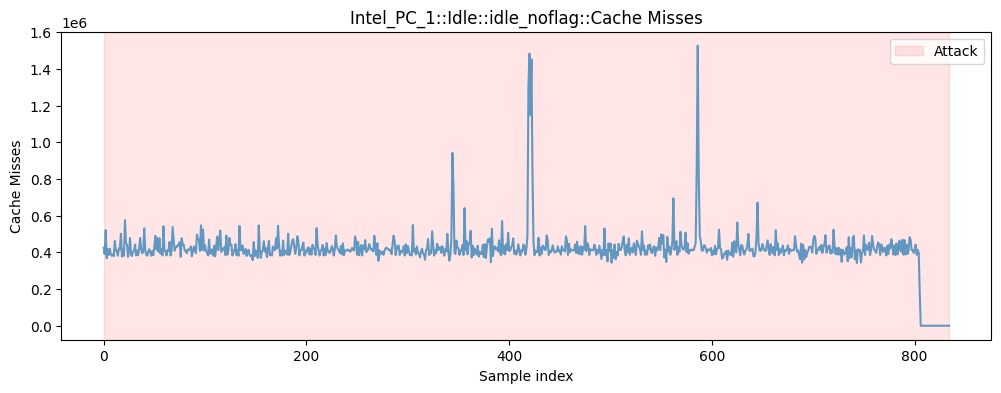

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(signal["time"]["values"], signal["values"], alpha=0.7)

# attack shading
lbl = np.array(signal["labels"]["values"])
if lbl.any():
    attack_idx = np.where(lbl == 1)[0]
    plt.axvspan(
        attack_idx[0],
        attack_idx[-1],
        color="red",
        alpha=0.1,
        label="Attack"
    )

plt.title(signal["signal_id"])
plt.xlabel("Sample index")
plt.ylabel(signal["metric"]["name"])
plt.legend()
plt.show()


In [14]:
def window_signal(signal, window_size, aggregation="mean"):
    if window_size <= 1:
        return signal  # no-op

    values = np.array(signal["values"])
    labels = np.array(signal["labels"]["values"])
    time = np.array(signal["time"]["values"])

    if aggregation == "mean":
        w = np.ones(window_size) / window_size
        win_values = np.convolve(values, w, mode="valid")
    else:
        raise ValueError(f"Unsupported aggregation: {aggregation}")

    # Conservative label alignment:
    # label a window as attack if ANY sample in the window is attack
    win_labels = np.array([
        int(labels[i:i+window_size].any())
        for i in range(len(win_values))
    ])

    win_time = time[:len(win_values)]

    return {
        **signal,
        "signal_id": signal["signal_id"] + f"::window={window_size}",
        "time": {
            "type": signal["time"]["type"],
            "values": win_time.tolist(),
        },
        "values": win_values.tolist(),
        "labels": {
            "type": signal["labels"]["type"],
            "values": win_labels.tolist(),
        },
        "transform": {
            "window_size": window_size,
            "aggregation": aggregation,
        },
    }


In [15]:
win_signal = window_signal(signal, window_size=50)

len(signal["values"]), len(win_signal["values"])


(835, 786)

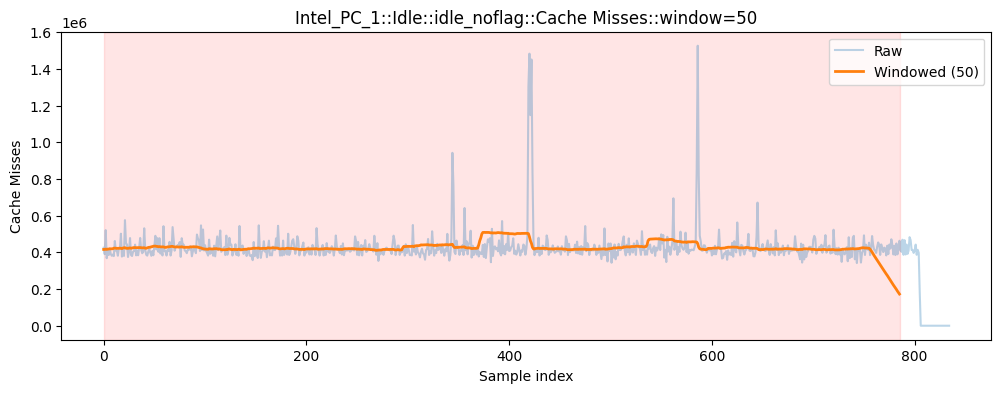

In [16]:
plt.figure(figsize=(12, 4))

# raw
plt.plot(
    signal["time"]["values"],
    signal["values"],
    alpha=0.3,
    label="Raw"
)

# windowed
plt.plot(
    win_signal["time"]["values"],
    win_signal["values"],
    linewidth=2,
    label="Windowed (50)"
)

# attack shading (from windowed labels)
lbl = np.array(win_signal["labels"]["values"])
in_attack = False
start = None

for i, v in enumerate(lbl):
    if v == 1 and not in_attack:
        start = i
        in_attack = True
    elif v == 0 and in_attack:
        plt.axvspan(start, i, color="red", alpha=0.1)
        in_attack = False

if in_attack:
    plt.axvspan(start, len(lbl), color="red", alpha=0.1)

plt.title(win_signal["signal_id"])
plt.xlabel("Sample index")
plt.ylabel(win_signal["metric"]["name"])
plt.legend()
plt.show()


In [17]:
def plot_time_series(
    signal,
    x_range=None,
    show_attack=True,
    ax=None,
    alpha=0.8,
    linewidth=1.5,
):
    """
    Plot a time-series Signal with optional attack shading and zoom.

    Parameters
    ----------
    signal : dict
        A Signal object (raw or windowed).
    x_range : tuple(int, int) or None
        (start, end) indices for zoom. View-only.
    show_attack : bool
        Whether to shade attack regions.
    ax : matplotlib axis or None
        Axis to plot on. Creates one if None.
    """

    time = np.array(signal["time"]["values"])
    values = np.array(signal["values"])
    labels = np.array(signal["labels"]["values"])

    # Apply zoom (view-only)
    if x_range is not None:
        start, end = x_range
        time = time[start:end]
        values = values[start:end]
        labels = labels[start:end]

    # Axis handling
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 4))

    # Plot signal
    ax.plot(
        time,
        values,
        alpha=alpha,
        linewidth=linewidth,
        label=signal["metric"]["name"],
    )

    # Attack shading
    if show_attack and labels.any():
        in_attack = False
        start_idx = None

        for i, v in enumerate(labels):
            if v == 1 and not in_attack:
                start_idx = time[i]
                in_attack = True
            elif v == 0 and in_attack:
                ax.axvspan(start_idx, time[i], color="red", alpha=0.1)
                in_attack = False

        if in_attack:
            ax.axvspan(start_idx, time[-1], color="red", alpha=0.1)

    # Labels & title
    ax.set_title(signal["signal_id"])
    ax.set_xlabel("Sample index")
    ax.set_ylabel(signal["metric"]["name"])
    ax.legend()

    return ax


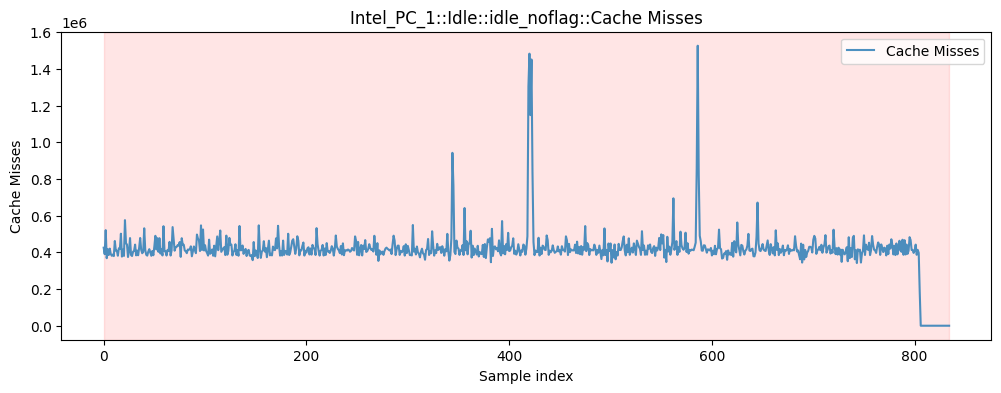

In [18]:
plot_time_series(signal)
plt.show()


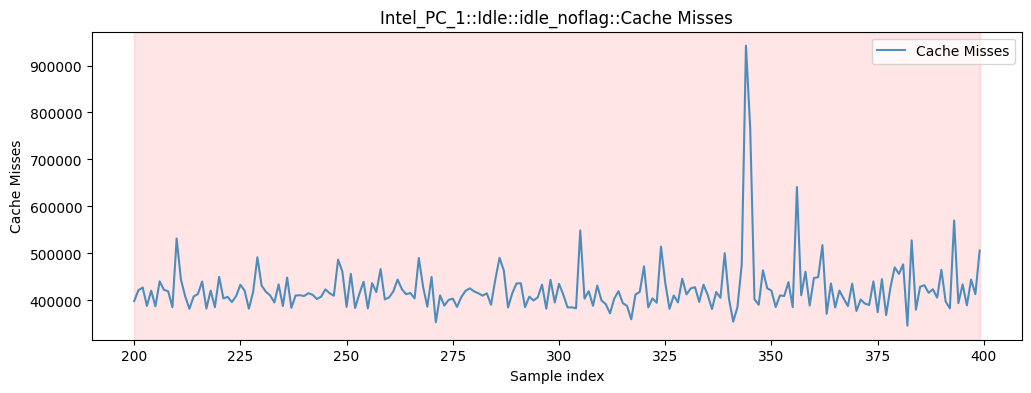

In [19]:
plot_time_series(signal, x_range=(200, 400))
plt.show()


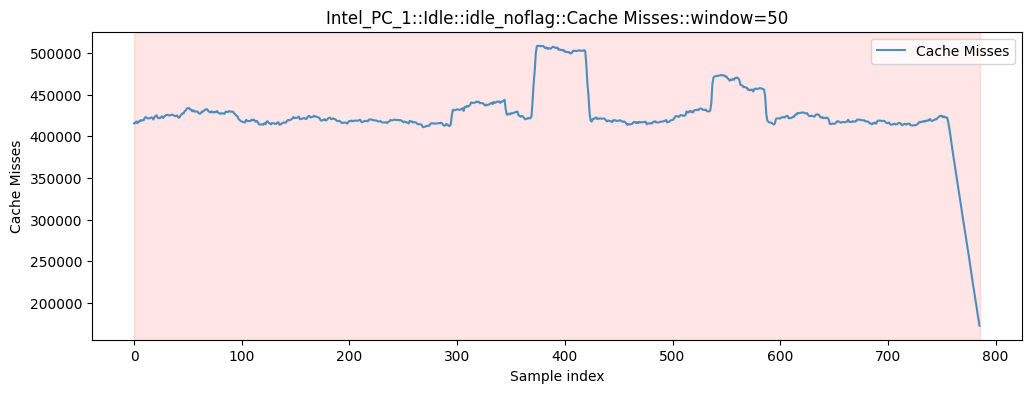

In [20]:
plot_time_series(win_signal)
plt.show()


In [23]:
def make_signal(
    device,
    workload,
    run,
    metric,
    data_root=DATA_ROOT,
):
    csv_path = data_root / device / workload / f"{run}.csv"
    df = pd.read_csv(csv_path)

    device_cfg = load_device_config(data_root, device)
    labels = derive_labels(df, device_cfg, metric)

    return {
        "signal_id": f"{device}::{workload}::{run}::{metric}",
        "source": {
            "device": device,
            "workload": workload,
            "run": run,
        },
        "metric": {
            "name": metric,
            "unit": "events",
        },
        "time": {
            "type": "index",
            "values": df["index"].tolist(),
        },
        "values": df[metric].tolist(),
        "labels": {
            "type": "attack",
            "values": labels.tolist(),
            "batch": find_metric_batch(device_cfg, metric),
        },
        "transform": {
            "window_size": 1,
            "aggregation": "none",
        },
    }


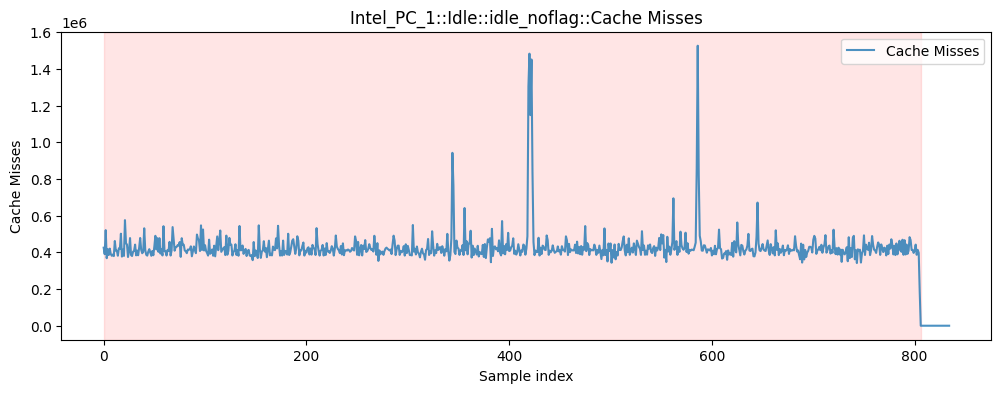

In [25]:
signal = make_signal(
    device="Intel_PC_1",
    workload="Idle",
    run="idle_noflag",
    metric="Cache Misses",
)

plot_time_series(signal)
plt.show()

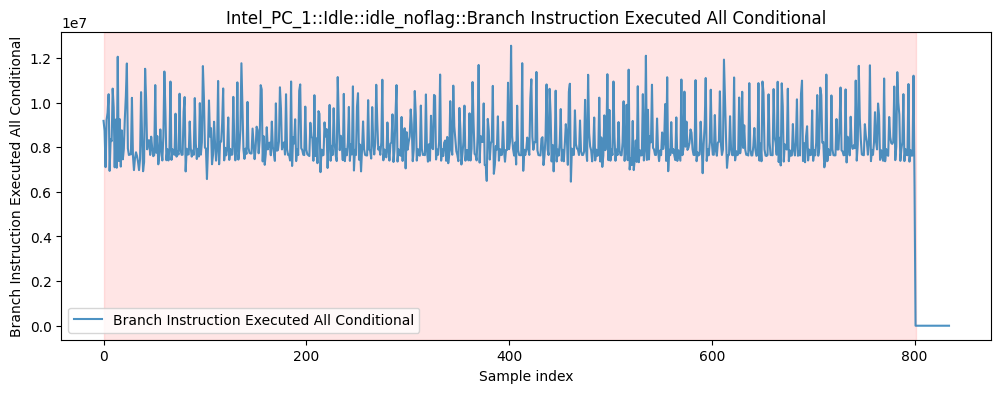

In [26]:
signal_2 = make_signal(
    device="Intel_PC_1",
    workload="Idle",
    run="idle_noflag",
    metric="Branch Instruction Executed All Conditional",
)
plot_time_series(signal_2)
plt.show()